<h1><center>Is a real emergency?</center></h1>
<p>Twitter has become an important communication channel in times of emergency. But some user use then to publish fakes emergencies. For this reason, is a good idea use ML to detect this fakes and alert other user of the possible fake.</p><p>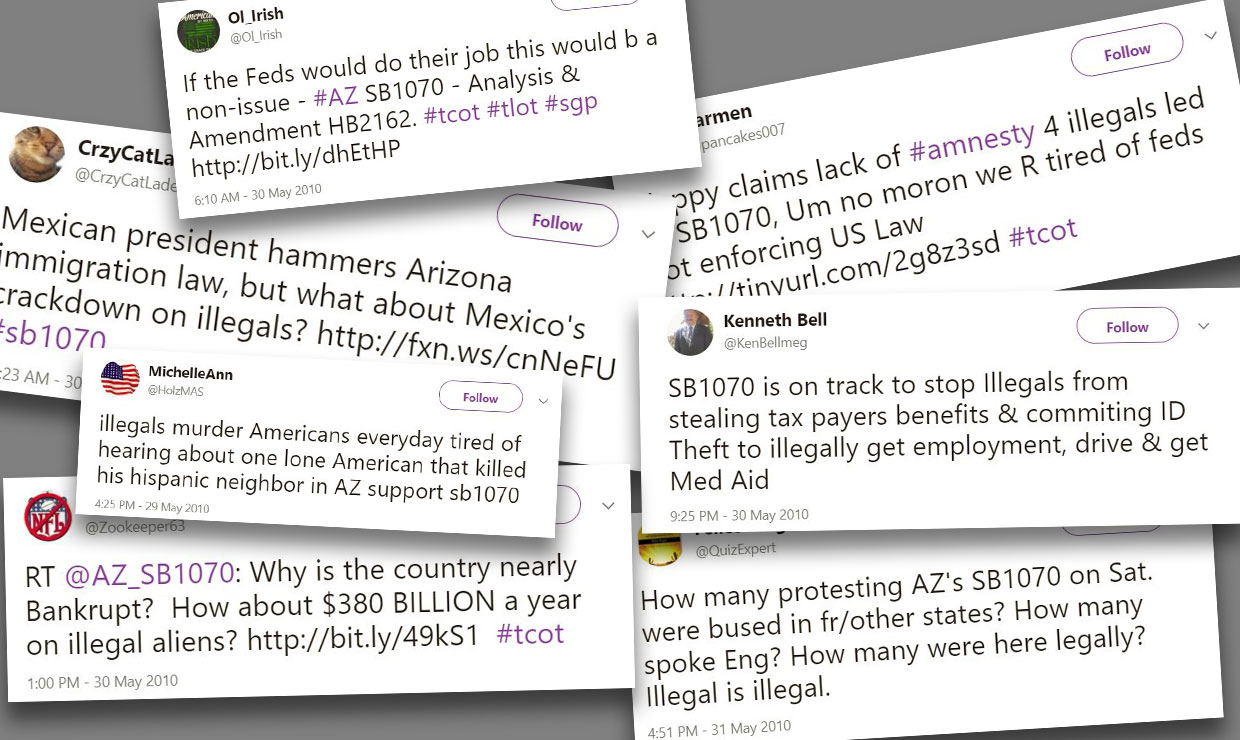</p>


In [ ]:
!pip install -q tensorflow-text

In [ ]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from IPython.display import clear_output
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import os
import gc

<h1>Preproccesing data</h1>

In [ ]:
PATH  = '../input/nlp-getting-started'
TRAIN = os.path.join(PATH, 'train.csv')
TEST  = os.path.join(PATH, 'test.csv')
SUBM  = os.path.join(PATH, 'sample_submission.csv')

In [ ]:
data = pd.read_csv(TRAIN)
data.head(15)

In [ ]:
test = pd.read_csv(TEST)
test.head(15)

In [ ]:
submission = pd.read_csv(SUBM)
submission.head(15)

In [ ]:
dataset = list([])
for i, text in enumerate(data['text']):
    dataset.append([text, data['target'][i]])
    
dataset[:25]

In [ ]:
text_ds = list([])
for text in dataset:
    text_ds.append(list([text[0]]))
    
text_ds[:10]

In [ ]:
len(text_ds)

In [ ]:
text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
text_ds = text_ds.shuffle(64)
text_ds = text_ds.batch(64, num_parallel_calls=tf.data.experimental.AUTOTUNE)
text_ds = text_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
bert_tokenizer_params = dict(
    lower_case      = False,
    keep_whitespace = False
)
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"] # Unnecessary for this case

bert_vocab_args = dict(
    vocab_size  = 2500,
    reserved_tokens = reserved_tokens,
    bert_tokenizer_params = bert_tokenizer_params,
    learn_params = {},
)

In [ ]:
%%time
vocab = bert_vocab.bert_vocab_from_dataset(text_ds, **bert_vocab_args)

In [ ]:
vocab.insert(4, ' ') # Add a <WHITESPACE> token

In [ ]:
len(vocab)

In [ ]:
import tensorflow_text as text

In [ ]:
tokenizer = text.FastWordpieceTokenizer(vocab)

def token_input(x):
    return x.split(' ')

def format_to_array(array, length=None):
    phrase  = []
    space   = vocab.index(' ')
    padding = vocab.index('[PAD]')
    for word in array:
        for subword in word:
            phrase.append(subword)
        phrase.append(space)
    phrase = phrase[:-1]
    phrase = phrase[:length]
    if length and len(phrase) != length:
        for i in range(len(phrase), length):
            phrase.insert(0, padding)

    return phrase

def detokenizer(phrase):
    output = ''
    for subword in phrase:
        if vocab[subword].startswith('##'):
            output += vocab[subword][2:]
        elif vocab[subword] not in ['[PAD]', '[UNK]', '[START]', '[END]']:
            output += vocab[subword]
            
    return output

In [ ]:
tokenized = tokenizer.tokenize(token_input('Is a real emergency?')).numpy()
tokenized = format_to_array(tokenized)
tokenized

In [ ]:
detokenizer(tokenized)

<h1>Make the dataset</h1>

In [ ]:
def index2sequence(i, maxlen):
    text = data['text'][i]
    text = format_to_array(tokenizer.tokenize(token_input(text)).numpy(), maxlen)
    text = tf.reshape(text, (1, maxlen))
    
    target = data['target'][i]
    target = list([float(target)])
    target = tf.reshape(target, (1, 1))
    
    return text, target

In [ ]:
residual_dataset = range(len(dataset))
len(residual_dataset)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(residual_dataset)
dataset = dataset.batch(1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
dataset

<h2>The Model</h2>
<p>Based on GPT-3 paper, I gonna use a little transformer architecture to improve the accuracy.</p><p>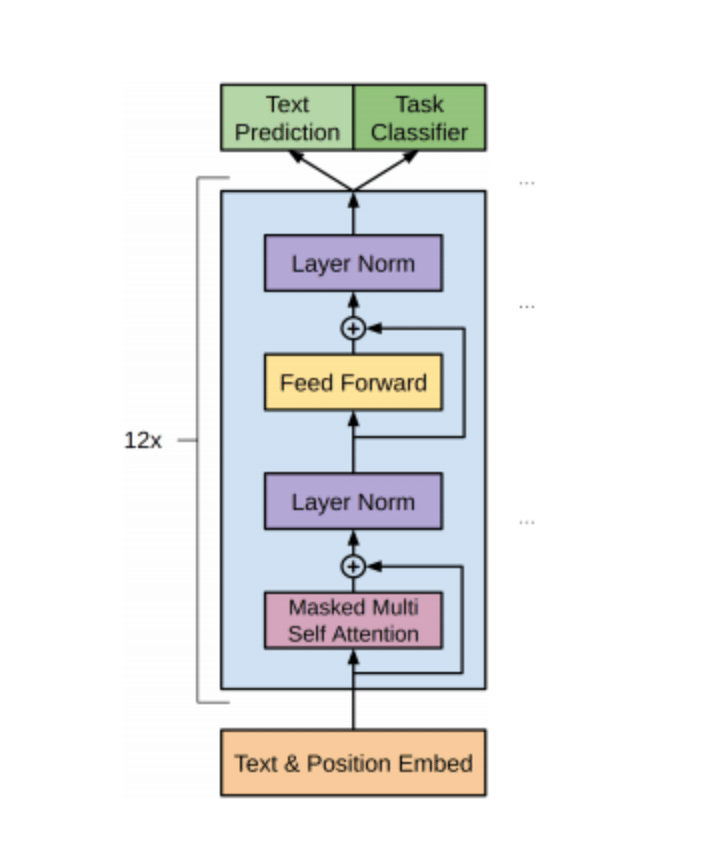
<i>Figure: Model architecture.</i></p>

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb   = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        x = self.token_emb(x)
        return x + positions

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = tf.keras.layers.Dropout(rate)
        self.drop2 = tf.keras.layers.Dropout(rate)
        self.wise1 = tf.keras.layers.Add()
        self.wise2 = tf.keras.layers.Add()

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size  = input_shape[0]
        seq_len     = input_shape[1]
        
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.drop1(attention_output)
        
        out1 = self.norm1(self.wise1([inputs, attention_output]))
        
        ffn_output = self.ffn(out1)
        ffn_output = self.drop2(ffn_output)
        
        return self.norm2(self.wise2([out1, ffn_output]))
    
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat([
            tf.expand_dims(batch_size, -1),
            tf.constant([1, 1], dtype=tf.int32)
        ], 0)
        
        return tf.tile(mask, mult)

In [ ]:
vocab_size = len(vocab) # Only consider the vocabulary size
maxlen     = 196        # Max sequence size
embed_dim  = 376       # Embedding size for each token
num_heads  = 6          # Number of attention heads
ff_dim     = 512       # Hidden layer size in feed forward network inside transformer

<h4>Modify the output layer to give a value between 0 and 1</h4>

In [ ]:
def GPTTask(num_blocks=1):
    inputs = tf.keras.layers.Input(shape=(maxlen,))
    
    x = PositionalEmbedding(maxlen, vocab_size, embed_dim)(inputs)
    
    for n in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.models.Model(inputs=inputs, outputs=x)

In [ ]:
model = GPTTask(num_blocks=2)
model.summary(120)

In [ ]:
if os.path.isfile('gpt_task.h5'):
    model = tf.keras.models.load_model('gpt_task.h5')
    print('Model restored!')

In [ ]:
for i in dataset.take(1):
    x, y = index2sequence(int(i), maxlen)
    print(model(x))

In [ ]:
optimizer = tf.optimizers.Adam(1e-4)
loss_fn_1 = tf.keras.losses.BinaryCrossentropy()
loss_fn_2 = tf.keras.losses.MeanSquaredError()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        pred = model(x, training=True)
        loss = loss_fn_1(y, pred)
        loss = loss_fn_2(y, pred) + loss
        grad = tape.gradient(loss, model.trainable_weights)
        
        optimizer.apply_gradients(zip(grad, model.trainable_weights))

    return loss

In [ ]:
EPOCHS = 22
LENGTH = len(dataset)
for epoch in range(EPOCHS):
    for step, i in enumerate(dataset):
        x, y = index2sequence(int(i), maxlen)
        loss = train_step(x, y)
        
        if step % 100 == 0:
            clear_output(wait=True)
            print(f'Epoch: [{(epoch + 1)}/{EPOCHS}] - Step: [{(step + 1)}/{LENGTH}] - Loss: {float(loss)}')

<p>The main disadvantage of use transformers is the long time that take the training.</p>

In [ ]:
for i, text in enumerate(test['text']):
    text = format_to_array(tokenizer.tokenize(token_input(text)).numpy(), maxlen)
    text = tf.reshape(text, (1, maxlen))
    pred = model(text)
    
    submission['target'][i] = int(round(float(pred)))
    
submission.head(15)

In [ ]:
# model.save('gpt_task.h5')

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
# PLEASE GIVE ME A UPVOTE AND FEEDBACK

<h3>Recomended next lecture: <a href="https://www.kaggle.com/lprdosmil/how-gaugan-2-works/notebook">How GauGan2 works</a></h3>